<a href="https://colab.research.google.com/github/nematatu/Colab-Python/blob/master/VGG16%E7%94%BB%E5%83%8F%E5%88%86%E9%A1%9E%E3%83%86%E3%82%B9%E3%83%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [187]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [188]:
!pip install -q bing_image_downloader
!pip install -q google-cloud-vision
!pip install -q tensorflow
!pip install -q Pillow
!pip -q install icrawler

In [189]:
from bing_image_downloader import downloader
from google.cloud import vision
import google.cloud.vision_v1.types as types
from PIL import Image as PILImage
from PIL import ImageOps
import os
import random
import shutil
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import glob
from scipy import ndimage
from icrawler.builtin import GoogleImageCrawler
from IPython.display import Image,display_jpeg
from google.colab import files

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras import optimizers
import numpy as np
import time

from google.colab import drive

In [190]:
!rm -rf ./ds ./img

In [191]:
drive.mount('/content/drive')
google_auth_path='/content/drive/MyDrive/Colab\ Notebooks/kasoon_colab/fluted-oath-407809-b8c332499f57.json'
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] ='/content/drive/MyDrive/開発/kasoon/fluted-oath-407809-b8c332499f57.json'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [192]:
SearchNames=['松本人志','イチロー']

for query_string in SearchNames:
  downloader.download(query_string,output_dir=r'./img',adult_filter_off=False,timeout=60,verbose= True)

[%] Downloading Images to /content/img/松本人志


[!!]Indexing page: 1

[%] Indexed 35 Images on Page 1.


[%] Downloading Image #1 from https://coconutsjapan.com/wp-content/uploads/2020/09/jiji_matsumoto_hitoshi.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.sankei.com/resizer/wEAxyZyY6OAc892HsiSVKEAas48=/730x0/smart/cloudfront-ap-northeast-1.images.arcpublishing.com/sankei/M22U52ITO5OTVDYERCVHDS6CXY.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.zakzak.co.jp/images/news/201207/enn2012070009-p1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://i.daily.jp/gossip/2020/12/22/Images/f_13957060.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://bunshun.ismcdn.jp/mwimgs/1/2/1500wm/img_127a9f62519d93bf25ff2d20e1bbfaa97066817.jpg
[!] Issue getting: https://bunshun.ismcdn.jp/mwimgs/1/2/1500wm/img_127a9f62519d93bf25ff2d20e1bbfaa97066817.jpg
[!] Error:: HTTP Error 403: Forbidden
[%] Downloading Image #5 from https://www.cinra.n

In [193]:
#def: 顔の検知&切り取り
def detect_face(image_path):
    client=vision.ImageAnnotatorClient()
    #コードブロックが終わったら自動でfileが閉じる
    #メモリの効率化
    #引数で取ったiamge_pathを'rb'バイナリファイルを読み込む
    with open(image_path, 'rb') as file:
        #読み込んだバイナリファイルを画像形式に変換している
        image=types.Image(content=file.read())
        #GCV APIのface_detection()を使って画像内の顔を検出する
        #そのうち、顔の情報を含むface_annotationsオブジェクトを返す
        annotations=client.face_detection(image=image).face_annotations

    face_boxes=[]

    for annotation in annotations:
        #annotation(顔の情報)の境界ボックス(bounding_poly)の座標情報(vertices)を取得
        #リスト内包表記で、うちx座標のみをリストに格納
        x_s=[vertex.x for vertex in annotation.bounding_poly.vertices]
        y_s=[vertex.y for vertex in annotation.bounding_poly.vertices]
        face_boxes.append((min(x_s),min(y_s),max(x_s),max(y_s)))

    # PILライブラリのImage.open()で画像を開く
    image = PILImage.open(image_path).convert('RGB')

    x1, y1, x2, y2 = face_boxes[0]

    w = x2 - x1
    h = y2 - y1

    spaces_x = min(x1, image.width - x2, int(float(w) * max_margin))
    spaces_y = min(y1, image.height - y2, int(float(h) * max_margin))
    margin = min(spaces_x, spaces_y)

    cropped_img = image.crop((
        x1 - margin,
        y1 - margin,
        x2 + margin,
        y2 + margin
    ))

    # ImageOps: 切り取り後のサイズに合わせる
    cropped_img = ImageOps.contain(cropped_img, image_size)

    return cropped_img

In [194]:
#def: データセットの分割
train_dir_path='./ds/train'
test_dir_path='./ds/test'

def split_dataset(image_dir_path):
  print("データセットの分割を開始します")
  file_list=os.listdir(image_dir_path)
  random.shuffle(file_list)

  dir_name=image_dir_path.split('/')[-1]
  train_size=int(len(file_list)*0.8)
  print(f"images:{int(len(file_list))}")
  print(f"train:{train_size}")
  if not os.path.exists('./ds'):
    os.mkdir('./ds')
    os.mkdir(train_dir_path)
    os.mkdir(test_dir_path)
  os.mkdir(os.path.join(test_dir_path,dir_name))
  os.mkdir(os.path.join(train_dir_path,dir_name))
  for i, file in enumerate(file_list):
    if i < train_size:
      shutil.copy(os.path.join(image_dir_path, file), os.path.join(train_dir_path,dir_name, file))
    else:
      shutil.copy(os.path.join(image_dir_path, file), os.path.join(test_dir_path, dir_name,file))
  print("データセットの分割が終了しました！")

In [195]:
#def: 底上げ
def false_buttom(in_dir,query_string):
  print(f"{query_string}の写真を水増しします")
  out_dir = "./img/Edited/" + query_string
  if not os.path.exists(os.path.join("./img","Edited")):
    os.mkdir(os.path.join("./img","Edited"))
  if not os.path.exists(out_dir):
    os.mkdir(out_dir)
  in_jpg = glob.glob(os.path.join(in_dir,'*'))
  for i in range(len(in_jpg)):
      img = cv2.imread(str(in_jpg[i]))
      print(str(in_jpg[i]))
      for ang in [-10, 0, 10]:
          img_rot = ndimage.rotate(img, ang)
          fileName = os.path.join(out_dir, str(i) + "_" + str(ang) + ".jpg")
          cv2.imwrite(str(fileName), img_rot)
          retval, img_thr = cv2.threshold(img_rot, 100, 255, cv2.THRESH_TOZERO)
          fileName = os.path.join(out_dir, str(i) + "_" + str(ang) + "thr.jpg")
          cv2.imwrite(str(fileName), img_thr)
          img_filter = cv2.GaussianBlur(img_rot, (5, 5), 0)
          fileName = os.path.join(out_dir, str(i) + "_" + str(ang) + "filter.jpg")
          cv2.imwrite(str(fileName), img_filter)
  print("画像の水増しに大成功しました！")

In [196]:
#顔周辺を切り取り
def crop_face(face_info, former_image):
    # PILライブラリのImage.open()で画像を開く
    image = PILImage.open(former_image).convert('RGB')

    x1, y1, x2, y2 = face_info[0]

    w = x2 - x1
    h = y2 - y1

    spaces_x = min(x1, image.width - x2, int(float(w) * max_margin))
    spaces_y = min(y1, image.height - y2, int(float(h) * max_margin))
    margin = min(spaces_x, spaces_y)

    cropped_img = image.crop((
        x1 - margin,
        y1 - margin,
        x2 + margin,
        y2 + margin
    ))

    # ImageOps: 切り取り後のサイズに合わせる
    cropped_img = ImageOps.contain(cropped_img, image_size)

    return cropped_img

In [197]:
#body
max_margin=0.2
image_size=(128,128)
for query_string in SearchNames:
  image_dir_path=os.path.join('./img',query_string)
  file_list=os.listdir(image_dir_path)
  for img in file_list:
      new_img=os.path.join(image_dir_path,img)
      target_name=image_dir_path.split('/')[-1]
      print(new_img)

      if img.endswith('.jpg') or img.endswith('.png') or img.endswith('.jpeg'):
          #faces=img+'_face'
          #GoogleDriveのパスを空白を含めないディレクトリに変更したら行けた
          cropped_img=detect_face(new_img)

          directory='face_cropped'
          new_directory=os.path.join('./img',directory,target_name)

          if not os.path.exists(os.path.join('./img',directory)):
            os.mkdir(os.path.join('./img',directory))
          if not os.path.exists(new_directory):
              os.mkdir(new_directory)

          cropped_img.save(os.path.join(new_directory,f'cropped_{img}'))

  false_buttom(os.path.join("./img","face_cropped",query_string),query_string)
  split_dataset(os.path.join('./img','Edited',query_string))



./img/松本人志/Image_4.jpg
./img/松本人志/Image_10.jpg
./img/松本人志/Image_30.jpg
./img/松本人志/Image_16.jpg
./img/松本人志/Image_5.jpg
./img/松本人志/Image_23.jpg
./img/松本人志/Image_29.jpg
./img/松本人志/Image_1.jpg
./img/松本人志/Image_15.jpg
./img/松本人志/Image_22.jpg
./img/松本人志/Image_9.jpg
./img/松本人志/Image_19.jpg
./img/松本人志/Image_12.jpg
./img/松本人志/Image_11.jpg
./img/松本人志/Image_21.jpg
./img/松本人志/Image_31.jpg
./img/松本人志/Image_2.jpg
./img/松本人志/Image_8.jpg
./img/松本人志/Image_6.jpg
./img/松本人志/Image_13.jpg
./img/松本人志/Image_17.jpeg
./img/松本人志/Image_14.jpg
./img/松本人志/Image_20.jpg
./img/松本人志/Image_24.png
./img/松本人志/Image_26.jpg
./img/松本人志/Image_18.jpg
./img/松本人志/Image_27.jpg
./img/松本人志/Image_7.jpg
./img/松本人志/Image_28.jpg
./img/松本人志/Image_25.jpg
./img/松本人志/Image_3.jpg
松本人志の写真を水増しします
./img/face_cropped/松本人志/cropped_Image_31.jpg
./img/face_cropped/松本人志/cropped_Image_7.jpg
./img/face_cropped/松本人志/cropped_Image_26.jpg
./img/face_cropped/松本人志/cropped_Image_22.jpg
./img/face_cropped/松本人志/cropped_Image_15.jpg
./img/face_cropped/松本人志/c

In [198]:
nb_classes=len(SearchNames)
img_width, img_height = 128, 128

#バッチサイズ
batch_size = 100
#エポック数
nb_epoch = 20

In [199]:
train_datagen=ImageDataGenerator(
   rescale=1.0/255,
)

validation_datagen=ImageDataGenerator(
   rescale=1.0/255,
)

In [200]:
train_generator = train_datagen.flow_from_directory(
  train_dir_path,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=SearchNames,
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
  test_dir_path,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=SearchNames,
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=True)


Found 453 images belonging to 2 classes.
Found 114 images belonging to 2 classes.


In [201]:
keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

In [202]:
# VGG16のロード。FC層は不要なので include_top=False
input_tensor = Input(shape=(img_width, img_height, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# VGG16の図の緑色の部分（FC層）の作成
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_classes, activation='softmax'))

# VGG16とFC層を結合してモデルを作成（完成図が上の図）
vgg_model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

# VGG16の図の青色の部分は重みを固定（frozen）
for layer in vgg_model.layers[:15]:
    layer.trainable = False

# 多クラス分類を指定
vgg_model.compile(loss='categorical_crossentropy',
          optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9),
          metrics=['accuracy'])


In [203]:
# Fine-tuning
history = vgg_model.fit(
    train_generator,
    steps_per_epoch=20,
    epochs=nb_epoch,
    validation_data=validation_generator,
    validation_steps=70)

Epoch 1/20
 5/20 [======>.......................] - ETA: 21s - loss: 0.8885 - accuracy: 0.5320

20/20 [==============================] - 10s 423ms/step - loss: 0.8885 - accuracy: 0.5320 - val_loss: 0.4420 - val_accuracy: 0.8070


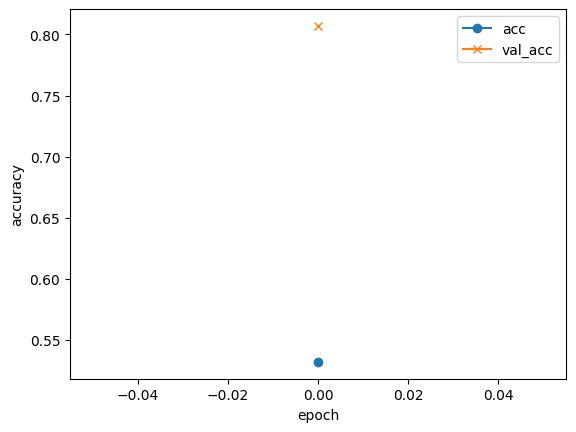

In [204]:
# 学習結果を描写
import matplotlib.pyplot as plt

#acc, val_accのプロット
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="o")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
#Final.pngという名前で、結果を保存
plt.savefig('Final1.png')
plt.show()


In [205]:
#resultsディレクトリを作成
result_dir = 'results'
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

# 重みを保存
vgg_model.save_weights(os.path.join(result_dir, 'Final.h5'))

# 作成したモデルを保存
# vgg_model.save('VGGtake1.h5')


In [206]:
from keras.preprocessing import image as keras_image

# 画像を読み込んで予測する
def img_predict(filename):
    # 画像を読み込んで4次元テンソルへ変換
    #full_path=os.path.join('img/shuffled_dir',filename)
    full_path=filename
    img = keras_image.load_img(full_path, target_size=(img_height, img_width))
    x = keras_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # 学習時にImageDataGeneratorのrescaleで正規化したので同じ処理が必要
    # これを忘れると結果がおかしくなるので注意
    x = x / 255.0
    #表示
    plt.imshow(img)
    plt.show()
    # 指数表記を禁止にする
    np.set_printoptions(suppress=True)

    #画像の人物を予測
    pred = vgg_model.predict(x)[0]
    max_idx=np.argmax(pred)
    predicted_class = SearchNames[max_idx]
    #結果を表示する
    print(SearchNames)
    print(f"{predicted_class}:{pred[max_idx]*100}")

In [207]:
def shuffle(img,person):
  person_dir=os.path.join(img,"face_cropped",person)

  file_list=os.listdir(person_dir)
  random.shuffle(file_list)

  shuffle_dir=os.path.join(img,'shuffled_dir')
  if not os.path.exists(shuffle_dir):
    os.mkdir(shuffle_dir)

  n=10
  for i, file in enumerate(file_list):
    if i < n:
      shutil.copy(os.path.join(person_dir, file), os.path.join(shuffle_dir, file))
    else:
      break


In [208]:
!rm -rf ./img/shuffled_dir

In [ ]:
f=files.upload()
file_name=list(f.keys())[0]

In [ ]:
#検索したい人のディレクトリの中でシャッフルしてる
# for person in SearchNames:
#   shuffle('./img',person)

In [ ]:
#予測したい画像ディレクトリを表示してる
for image in os.listdir('img/松本人志'):
  display(Image(os.path.join('img/松本人志',image)))
  print(image)

In [ ]:
#予測
# for file in os.listdir('img/shuffled_dir'):
#   img_predict(file)

detect_file=detect_face(file_name)
detect_file.save(os.path.join('.','matsumoto.jpg'))
img_predict('matsumoto.jpg')